In [1]:
import os
import pickle
import copy
import logging
import matplotlib.pyplot as plt

from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ConformationEnsemble import ConformationEnsembleLibrary

In [2]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [3]:
data_dir_path = 'data/'

In [4]:
sdsupplier = Chem.rdmolfiles.SDMolSupplier(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf'))
platinum_mols = [mol for mol in sdsupplier]

In [14]:
len(platinum_mols)

4548

In [25]:
with open(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf')) as f :
    lines = f.readlines()
    lines = [line.strip() for line in lines]

In [45]:
pdb_ids = []
new_mol = True
for line in lines :
    if new_mol :
        pdb_ids.append(line)
        new_mol = False
    if line == '$$$$' :
        new_mol = True

In [50]:
n_heavy_atoms = [mol.GetNumHeavyAtoms() for mol in platinum_mols]

(array([462., 407., 654., 574., 622., 719., 463., 343., 210.,  94.]),
 array([10. , 13.4, 16.8, 20.2, 23.6, 27. , 30.4, 33.8, 37.2, 40.6, 44. ]),
 <BarContainer object of 10 artists>)

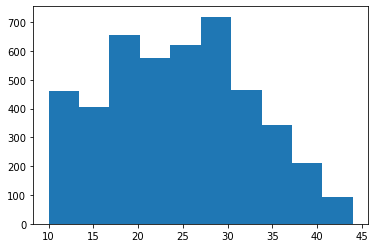

In [51]:
plt.hist(n_heavy_atoms)

In [56]:
def ccdc_conformers_to_rdkit_mol(ccdc_conformers, rdkit_mol) :
        
    generated_conf_ids = []

    for conformer in ccdc_conformers :
        new_rdkit_conf = copy.deepcopy(rdkit_mol).GetConformer()
        for i in range(new_rdkit_conf.GetNumAtoms()) :
            atom = conformer.molecule.atoms[i]
            point3d = Point3D(*atom.coordinates)
            new_rdkit_conf.SetAtomPosition(i, point3d)
        new_rdkit_conf.SetProp('Generator', 'CCDC')
        conf_id = rdkit_mol.AddConformer(new_rdkit_conf, assignId=True)
        generated_conf_ids.append(conf_id)

    return generated_conf_ids

In [57]:
initial_ccdc_mols = []
corresponding_mols = []
for i, mol in enumerate(tqdm(platinum_mols)) :
    mol.GetConformer().SetProp('PDB_ID', pdb_ids[i])
    mol2block = Chem.MolToMolBlock(mol)
    ccdc_mol = Molecule.from_string(mol2block)
    if mol.GetNumAtoms() == len(ccdc_mol.atoms) :
        initial_ccdc_mols.append(ccdc_mol)
        corresponding_mols.append(mol)

100%|█████████████████████████████████████| 4548/4548 [00:01<00:00, 3685.06it/s]


In [61]:
n_mol_per_chunk = 100
chunk_idxs = [list(range(i, i + n_mol_per_chunk)) for i in range(0, len(platinum_mols), n_mol_per_chunk)]

In [62]:
ccdc_conformer_generator = ConformerGenerator(nthreads=12)
ccdc_conformer_generator.settings.max_conformers = 50

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


In [63]:
generated_mols = []
for chunk_idx in tqdm(chunk_idxs) :
    
    ccdc_mols = [mol for i, mol in enumerate(initial_ccdc_mols) if i in chunk_idx]
    rdkit_mols = [mol for i, mol in enumerate(corresponding_mols) if i in chunk_idx]
    
    conformers = ccdc_conformer_generator.generate(ccdc_mols)
    
    for rdkit_mol, conformers in zip(rdkit_mols, conformers) :
        try :
            generated_conf_ids = ccdc_conformers_to_rdkit_mol(conformers, rdkit_mol)
            generated_mols.append(rdkit_mol)
        except Exception as e :
            print(e)

  0%|                                                    | 0/46 [00:00<?, ?it/s]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  2%|▉                                           | 1/46 [00:23<17:54, 23.88s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  4%|█▉                                          | 2/46 [00:44<16:12, 22.10s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  7%|██▊                                         | 3/46 [01:06<15:45, 22.00s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


  9%|███▊                                        | 4/46 [01:27<15:05, 21.57s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 13%|█████▋                                      | 6/46 [02:22<16:14, 24.36s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 17%|███████▋                                    | 8/46 [02:59<13:27, 21.25s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 20%|████████▌                                   | 9/46 [03:20<12:55, 20.96s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 22%|█████████▎                                 | 10/46 [03:39<12:10, 20.30s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 24%|██████████▎                                | 11/46 [03:59<11:49, 20.27s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 26%|███████████▏                               | 12/46 [04:17<11:08, 19.65s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 28%|████████████▏                              | 13/46 [04:36<10:38, 19.36s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 30%|█████████████                              | 14/46 [04:56<10:26, 19.59s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 33%|██████████████                             | 15/46 [06:27<21:18, 41.24s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 35%|██████████████▉                            | 16/46 [06:47<17:24, 34.82s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 37%|███████████████▉                           | 17/46 [07:10<15:06, 31.25s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 39%|████████████████▊                          | 18/46 [07:31<13:07, 28.13s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 41%|█████████████████▊                         | 19/46 [07:51<11:31, 25.61s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 48%|████████████████████▌                      | 22/46 [08:50<08:36, 21.51s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 54%|███████████████████████▎                   | 25/46 [09:42<06:37, 18.93s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 57%|████████████████████████▎                  | 26/46 [10:02<06:21, 19.08s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 59%|█████████████████████████▏                 | 27/46 [10:20<05:59, 18.92s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 61%|██████████████████████████▏                | 28/46 [10:37<05:30, 18.36s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 63%|███████████████████████████                | 29/46 [10:55<05:07, 18.06s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 65%|████████████████████████████               | 30/46 [11:17<05:07, 19.24s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 70%|█████████████████████████████▉             | 32/46 [12:03<04:49, 20.70s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 72%|██████████████████████████████▊            | 33/46 [12:23<04:23, 20.23s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 78%|█████████████████████████████████▋         | 36/46 [13:18<03:08, 18.86s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 80%|██████████████████████████████████▌        | 37/46 [13:38<02:50, 18.97s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 83%|███████████████████████████████████▌       | 38/46 [14:02<02:44, 20.56s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 91%|███████████████████████████████████████▎   | 42/46 [15:16<01:16, 19.14s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


 98%|██████████████████████████████████████████ | 45/46 [16:16<00:19, 19.54s/it]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


100%|███████████████████████████████████████████| 46/46 [16:28<00:00, 21.48s/it]


In [11]:
# 41% : 20 min
# 17 s/it = 17s/100mol

In [64]:
n_confs = [mol.GetNumConformers() for mol in generated_mols]

(array([ 359.,  158.,  170.,   67.,   90.,   56.,   74.,   45.,   55.,
          42.,   30.,   48.,   43.,   42.,   20.,   39.,   20.,   24.,
          21., 3145.]),
 array([ 2.  ,  4.45,  6.9 ,  9.35, 11.8 , 14.25, 16.7 , 19.15, 21.6 ,
        24.05, 26.5 , 28.95, 31.4 , 33.85, 36.3 , 38.75, 41.2 , 43.65,
        46.1 , 48.55, 51.  ]),
 <BarContainer object of 20 artists>)

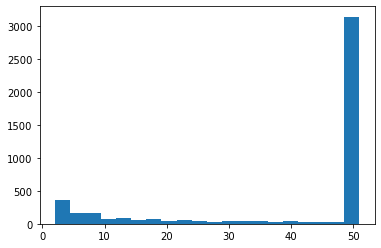

In [65]:
import matplotlib.pyplot as plt
plt.hist(n_confs, bins=20)

In [66]:
generated_CEL = ConformationEnsembleLibrary(generated_mols)

100%|████████████████████████████████████| 4548/4548 [00:00<00:00, 13237.19it/s]


In [67]:
with open(os.path.join(data_dir_path, 'raw', 'platinum_conf_ensemble_library_ccdc_generated.p'), 'wb') as f :
    pickle.dump(generated_CEL, f)
    
# here we only have the molecules parsed identically by RDKit (from mol2) and CSD (from smiles)